In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_dir = '/content/drive/MyDrive/AI&ML/DevanagariHandwrittenDigitDataset'

1. Dataset Preparation and Preprocessing:
• Load the Devnagari dataset using PIL.
• Normalize the images to the range [0, 1].
• Reshape the images to include a channel dimension for Keras Compatibility.
• Split the dataset into training and validation sets.
• Add noise to the images for denoising purposes (Gaussian noise or salt-and-pepper noise).

 Import Necessary Libraries

In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


Configuration and Directory Setup

In [4]:
img_size = 32  # Based on Devnagari digit dataset
data_dir = '/content/drive/MyDrive/AI&ML/DevanagariHandwrittenDigitDataset'
train_dir = os.path.join(data_dir, 'Train')
test_dir = os.path.join(data_dir, 'Test')


 Load Images from Folders

In [5]:
def load_images_from_folder(folder):
    images = []
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                if img_file.endswith('.png'):
                    img_path = os.path.join(class_path, img_file)
                    img = Image.open(img_path).convert('L').resize((img_size, img_size))
                    img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize to [0,1]
                    images.append(img_array)
    return np.array(images)


Load and Preprocess Training and Testing Data

In [6]:
x_train = load_images_from_folder(train_dir)
x_test = load_images_from_folder(test_dir)

 Reshape Data for Keras


In [7]:
x_train = np.reshape(x_train, (-1, img_size, img_size, 1))
x_test = np.reshape(x_test, (-1, img_size, img_size, 1))

 Add Gaussian Noise to the Images

In [8]:
def add_gaussian_noise(images, noise_factor=0.5):
    noisy = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return np.clip(noisy, 0., 1.)

x_train_noisy = add_gaussian_noise(x_train, noise_factor=0.5)
x_test_noisy = add_gaussian_noise(x_test, noise_factor=0.5)


Visualize a Few Sample Images

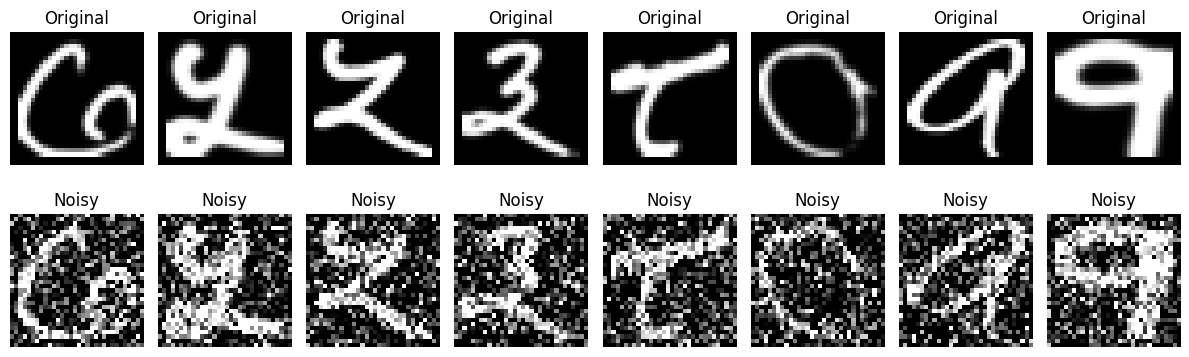

In [9]:
n = 8  # number of images to display

# Get random indices to display different images
random_indices = np.random.choice(len(x_train), n, replace=False)

plt.figure(figsize=(12, 4))
for j, idx in enumerate(random_indices):
    # Original image
    ax = plt.subplot(2, n, j + 1)
    plt.imshow(x_train[idx].reshape(img_size, img_size), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Noisy image
    ax = plt.subplot(2, n, j + 1 + n)
    plt.imshow(x_train_noisy[idx].reshape(img_size, img_size), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

plt.tight_layout()
plt.show()


2. Build the Denoising Convolutional Autoencoder:
Build a convolutional autoencoder with at least 4 layers. The model should have an encoder to
compress the input and a decoder to reconstruct the original image.
• Use convolutional layers for the encoder and decoder.
• Use ReLU activations for hidden layers and sigmoid for the output layer.
Expected Deliverables:
• A Complete rendered IPYTHON Notebook, with appropriate visualization and Results.

Encoder Section

In [10]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [11]:
def build_encoder(input_shape=(32, 32, 1)):
    input_img = Input(shape=input_shape, name='input')

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)  # 16x16

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # 8x8

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # 4x4

    encoded = Conv2D(256, (3, 3), activation='relu', padding='same', name='encoded')(x)  # 4x4x256

    return input_img, encoded


Decoder Section

In [12]:
def build_decoder(encoded_input):
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded_input)
    x = UpSampling2D((2, 2))(x)  # 8x8

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # 16x16

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # 32x32

    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoded')(x)

    return decoded


Autoencoder Model

In [13]:
def build_autoencoder():
    input_img, encoded_output = build_encoder()
    decoded_output = build_decoder(encoded_output)

    autoencoder = Model(inputs=input_img, outputs=decoded_output, name="autoencoder")
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    return autoencoder


Model Summary

In [14]:

autoencoder = build_autoencoder()
autoencoder.summary()


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (Conv2D)                │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoded (Conv2D)                │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 775,425 (2.96 MB)

 Trainable params: 775,425 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

3. Train the Denoising Autoencoder:
Train the model with the noisy images as inputs and the original images as targets. Monitor the training
process by plotting the loss curves.

Training the Autoencoder

In [15]:
import matplotlib.pyplot as plt


In [16]:
history = autoencoder.fit(
    x_train_noisy, x_train,  # Noisy input → Clean output
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)


Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - loss: 0.4523 - val_loss: 0.2207
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2080 - val_loss: 0.1820
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1792 - val_loss: 0.1782
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1693 - val_loss: 0.1631
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1628 - val_loss: 0.1591
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1573 - val_loss: 0.1554
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1540 - val_loss: 0.1531
Epoch 8/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1515 - val_loss: 0.1515
Epoch 9/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1498 - val_loss: 0.1494
Epoch 10/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1470 - val_loss: 0.1487
Epoch 11/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1462 - val_loss: 0.1489
Epoch 12/20
133/133 ━━━━━━━━━━━━━━━━━━━━

Plotting the Loss

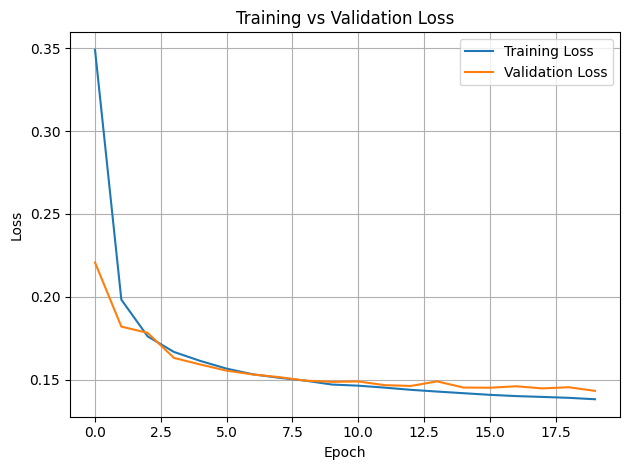

In [17]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

#Final Touch: Beautify the Plot
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


4. Evaluate and Visualize the Results:
Evaluate the performance of the denoising autoencoder by visualizing a few noisy images, the denoised
images generated by the model, and the original clean images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step


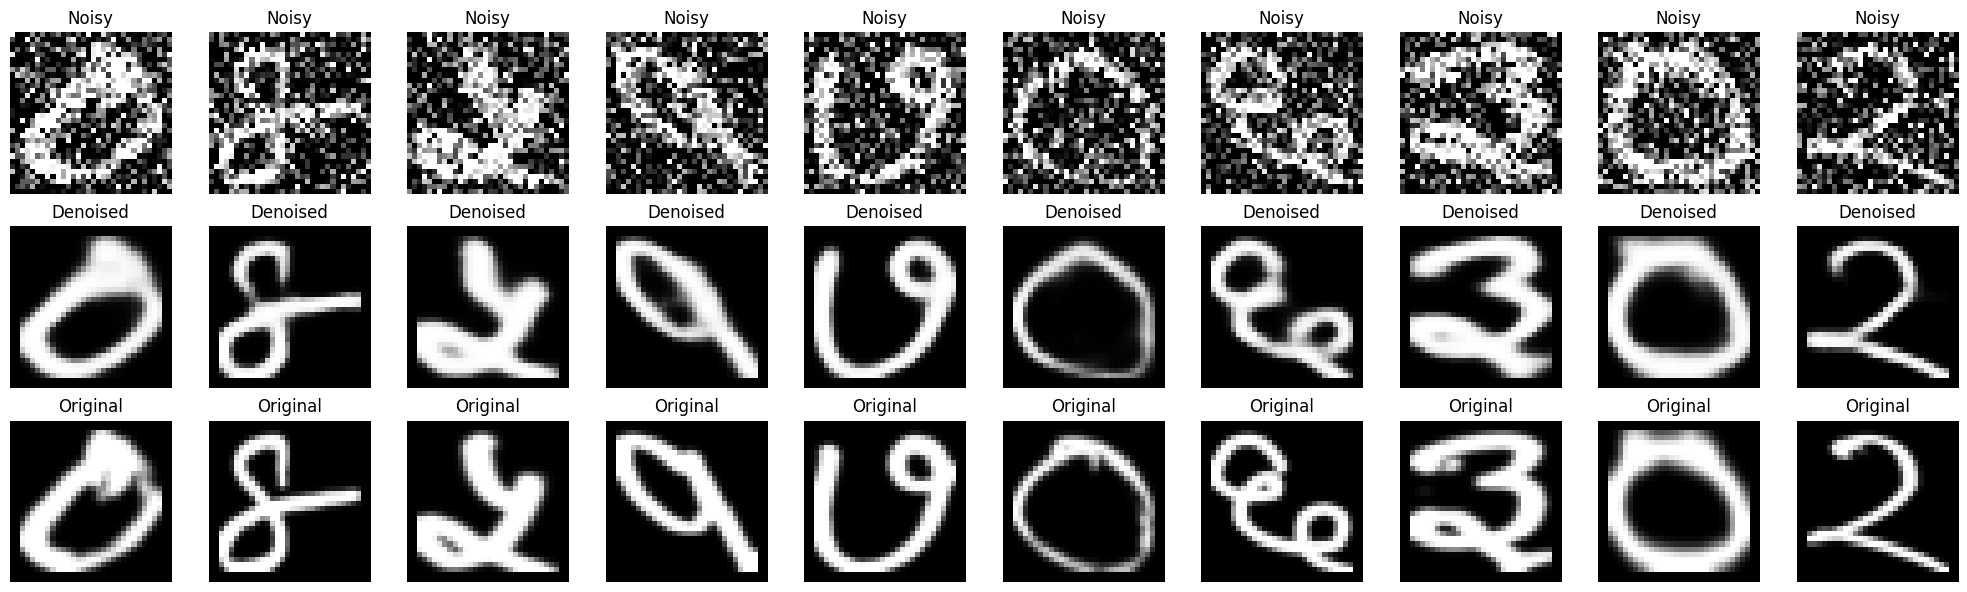

In [18]:

# Number of images to display
n = 10

# Get random indices from the test set
random_indices = np.random.choice(len(x_test), n, replace=False)

# Predict denoised images using the same indices
denoised_images = autoencoder.predict(x_test_noisy[random_indices])

# Function to display noisy → denoised → original side by side
def plot_images(noisy, denoised, original, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Noisy Image
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(noisy[i].reshape(32, 32), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # Denoised Output
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised[i].reshape(32, 32), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')

        # Original Clean Image
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(original[i].reshape(32, 32), cmap='gray')
        plt.title("Original")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function using random samples
plot_images(x_test_noisy[random_indices], denoised_images, x_test[random_indices], n=n)



5. Experiment and Fine - Tune the Model:
Try varying the model’s architecture, noise levels, or training parameters. Experiment with different
numbers of layers, filters, and noise factors. Record your observations about how these changes affect
the model’s performance.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step


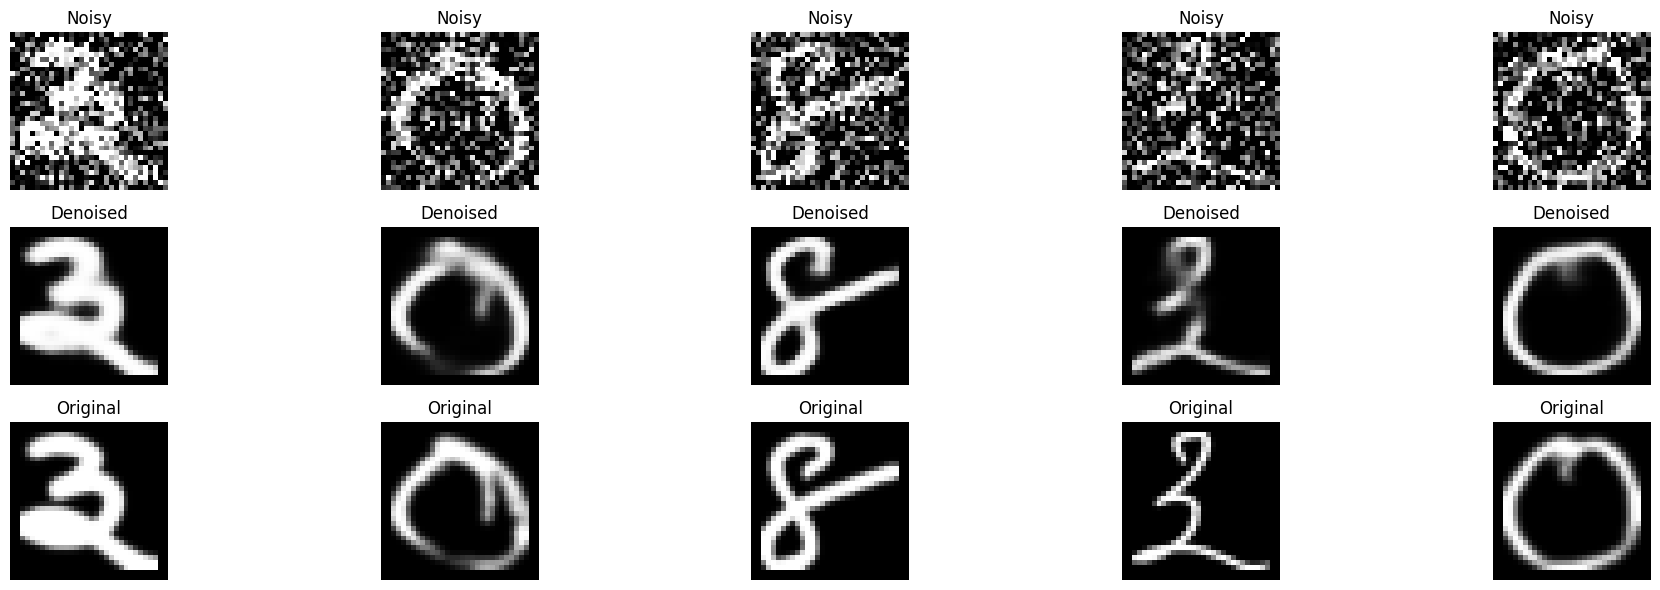

In [19]:


# Function to get random samples and their predictions
def get_random_samples(noisy_data, clean_data, model, n=5):
    indices = np.random.choice(len(noisy_data), n, replace=False)
    noisy_samples = noisy_data[indices]
    clean_samples = clean_data[indices]
    denoised_samples = model.predict(noisy_samples)
    return noisy_samples, denoised_samples, clean_samples

# Function to plot noisy → denoised → original
def plot_images(noisy, denoised, original, n=5):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Noisy
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(noisy[i].reshape(32, 32), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # Denoised
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised[i].reshape(32, 32), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')

        # Original
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(original[i].reshape(32, 32), cmap='gray')
        plt.title("Original")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# === USAGE ===
n = 5
noisy_samples, denoised_samples, clean_samples = get_random_samples(x_test_noisy, x_test, autoencoder, n=n)
plot_images(noisy_samples, denoised_samples, clean_samples, n=n)
